# Stock Market Price Prediction
## Time Series Forecasting with RNN

We will use a Recurrent Neural Network model to predict stock prices based on historical stock price data.

### Importing required packages

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D
from sklearn.preprocessing import MinMaxScaler

### Reading dataset
Let's take a look at the first few rows of the dataset and check if the data has any missing values.

In [56]:
df = pd.read_csv('data.csv')
# Convert date to datetime format and set index to Date
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2012-01-03 to 2016-11-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1237 non-null   float64
 1   High    1237 non-null   float64
 2   Low     1237 non-null   float64
 3   Close   1237 non-null   object 
 4   Volume  1237 non-null   object 
dtypes: float64(3), object(2)
memory usage: 58.0+ KB


We can see that there are no missing values.

We need to convert the Close and Volume columns to float format.

In [57]:
df['Close'] = df['Close'].replace({',': ''}, regex=True).astype(float)
df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,7380500.0
2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2012-01-05,329.83,330.75,326.89,657.21,6590300.0
2012-01-06,328.34,328.77,323.68,648.24,5405900.0
2012-01-09,322.04,322.29,309.46,620.76,11688800.0


### Preparing training and test data
We shall extract the last two weeks records into the test dataset, as well as the two weeks prior to that as the model will predict the stock price on a certain day based on the previous two weeks' data.

In [58]:
test_df = df.last('30D')
train_df = df.drop(test_df.index, axis=0)

We will use the 'Close' column to train the model.

In [59]:
train = train_df['Close'].values.reshape(-1,1)
test = test_df['Close'].values.reshape(-1,1)

### Scaling and reshaping data
We will the scale the data to values between 0 and 1 for better performance of the model.

In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

We will format the data into a 3D array and take a timestep of 10 elements. The 10 previous records will be used by the model to predict the next one.

In [61]:
trainX = []
trainY = []
testX = []
testY = []

# Create the training dataset
for i in range(len(train) - 11):
    trainX.append(train_scaled[i:i+10, 0])
    trainY.append([train_scaled[i+10, 0]])
trainX = np.array(trainX)
trainY =  np.array(trainY)

# Create the testing dataset
for i in range(len(test) - 11):
    testX.append(test_scaled[i:i+10, 0])
    testY.append([test_scaled[i+10, 0]])
testX = np.array(testX)
testY = np.array(testY)

# Convert the training and testing data into a 3-d shape for input
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

### Creating and compiling RNN model
We will create a simple RNN model using LSTMs.

In [62]:
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(trainX.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_16 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


The model is compiled with 'Adam' optimizer. We are using the Mean Squared Error metric to compute loss.

In [63]:
model.compile(optimizer='adam',
              loss='mean_squared_error', 
              metrics=['accuracy', 'mse'])

### Training the model

In [64]:
model.fit(trainX, 
          trainY, 
          epochs=40, 
          batch_size=32, 
          verbose=1)

Epoch 1/40
38/38 [==============================] - 15s 32ms/step - loss: 0.0359 - accuracy: 0.0017 - mse: 0.0359
Epoch 2/40
38/38 [==============================] - 1s 31ms/step - loss: 0.0068 - accuracy: 0.0017 - mse: 0.0068
Epoch 3/40
38/38 [==============================] - 1s 39ms/step - loss: 0.0059 - accuracy: 0.0017 - mse: 0.0059
Epoch 4/40
38/38 [==============================] - 2s 40ms/step - loss: 0.0052 - accuracy: 0.0017 - mse: 0.0052
Epoch 5/40
38/38 [==============================] - 2s 60ms/step - loss: 0.0053 - accuracy: 0.0017 - mse: 0.0053
Epoch 6/40
38/38 [==============================] - 2s 44ms/step - loss: 0.0048 - accuracy: 0.0017 - mse: 0.0048
Epoch 7/40
38/38 [==============================] - 1s 35ms/step - loss: 0.0044 - accuracy: 0.0017 - mse: 0.0044
Epoch 8/40
38/38 [==============================] - 1s 37ms/step - loss: 0.0049 - accuracy: 0.0017 - mse: 0.0049
Epoch 9/40
38/38 [==============================] - 1s 40ms/step - loss: 0.0039 - accuracy: 0.0

### Making Predictions
Using the trained model, we'll forecast stock prices for the next two weeks.

In [71]:
test_pred = model.predict(testX)
test_pred = scaler.inverse_transform(test_pred)
test_actual = scaler.inverse_transform(testY)
test_pred

1/1 [==============================] - 0s 56ms/step


array([[750.3924 ],
       [748.22504],
       [750.1842 ],
       [754.5523 ],
       [758.0443 ],
       [761.4277 ],
       [763.4864 ],
       [762.8525 ],
       [762.37244],
       [763.69293]], dtype=float32)

### Saving the results
The predicted stock prices are output to result.csv file.

In [72]:
np.savetxt('result.csv', test_pred, delimiter=",")

### Evaluating the model

In [73]:
score = model.evaluate(testX, testY, verbose=0) 

print('Test loss (Mean Squared Error):', score[0]) 
print('Test accuracy:', score[1])

Test loss (Mean Squared Error): 0.03621643781661987
Test accuracy: 0.0


Let's plot the predicted stock prices against the actual ones.

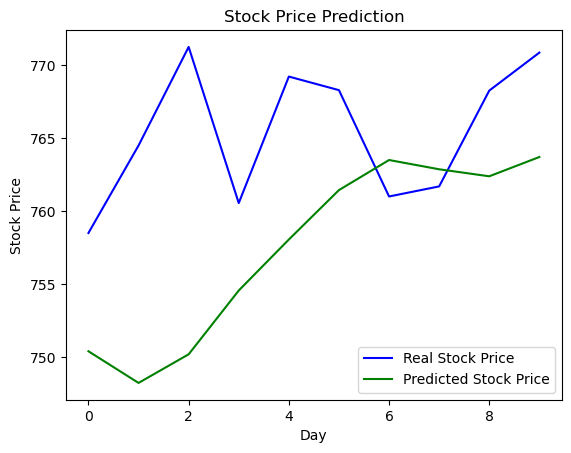

In [74]:
plt.plot(test_actual, color = 'blue', label = 'Real Stock Price')
plt.plot(test_pred, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()